**#0 Importy**

In [15]:
# manipulacja danymi
import numpy as np
import pandas as pd

# wizualizacja
import matplotlib.pyplot as plt
import seaborn as sns

# podział danych na zbiory treningowe/walidacyjne/testowe
from sklearn.model_selection import train_test_split, GridSearchCV

# budowa Pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# preprocessing
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures

# redukcja wymiarowości
from sklearn.decomposition import PCA

# model
from sklearn.linear_model import LogisticRegression

# ewaluacja
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, f1_score, roc_auc_score

**#1 Wczytanie bazy i przygotowanie danych**

In [16]:
diabetes = pd.read_csv('diabetes.csv')
diabetes

,PatientID,Pregnancies,PlasmaGlucose,DiastolicBloodPressure,TricepsThickness,SerumInsulin,BMI,DiabetesPedigree,Age,Diabetic
0,1354778,0,171,80,34,23,43.509726,1.213191,21,0
1,1147438,8,92,93,47,36,21.240576,0.158365,23,0
2,1640031,7,115,47,52,35,41.511523,0.079019,23,0
3,1883350,9,103,78,25,304,29.582192,1.282870,43,1
4,1424119,1,85,59,27,35,42.604536,0.549542,22,0
...,...,...,...,...,...,...,...,...,...,...
14995,1490300,10,65,60,46,177,33.512468,0.148327,41,1
14996,1744410,2,73,66,27,168,30.132636,0.862252,38,1
14997,1742742,0,93,89,43,57,18.690683,0.427049,24,0
14998,1099353,0,132,98,18,161,19.791645,0.302257,23,0


In [17]:
diabetes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   PatientID               15000 non-null  int64  
 1   Pregnancies             15000 non-null  int64  
 2   PlasmaGlucose           15000 non-null  int64  
 3   DiastolicBloodPressure  15000 non-null  int64  
 4   TricepsThickness        15000 non-null  int64  
 5   SerumInsulin            15000 non-null  int64  
 6   BMI                     15000 non-null  float64
 7   DiabetesPedigree        15000 non-null  float64
 8   Age                     15000 non-null  int64  
 9   Diabetic                15000 non-null  int64  
dtypes: float64(2), int64(8)
memory usage: 1.1 MB


In [18]:
X = diabetes.drop(['PatientID', 'Diabetic'], axis=1).copy()
y = diabetes['Diabetic'].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

**#2 Funkcja do obliczania metryk**

In [19]:
metrics_dataframe = pd.DataFrame(columns = ['Model', 'F1_score', 'AUC'])
metrics_dataframe
models = []
models_names = []
predictions_proba_list = []

def calculate_metrics(model, name, X_checked, y_checked):
    models.append(model)
    models_names.append(name)
    global metrics_dataframe
    predictions = model.predict(X_checked)
    predictions_proba = model.predict_proba(X_checked)
    predictions_proba_list.append(predictions_proba[:,1])

    ############## metryki dla sprawdzanego modelu ################

    # Precision, Recall, F1, Accuracy
    print(classification_report(y_checked, predictions))

    # Confusion matrix
    plt.figure()
    cm = confusion_matrix(y_checked, predictions)
    ax = sns.heatmap(cm, annot=True, cmap='Blues', fmt='.0f')
    ax.set_title('Confusion Matrix\n\n')
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ')
    plt.show()

    # plot ROC curve
    fig = plt.figure(figsize=(6, 6))
    plt.plot([0, 1], [0, 1], 'k--')
    for model_selected, name_selected, pred_proba in zip(models, models_names, predictions_proba_list):
        fpr, tpr, thresholds = roc_curve(y_checked, pred_proba)
        plt.plot(fpr, tpr, label=name_selected)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

    f1_metric = f1_score(y_checked, predictions)
    auc_metric = roc_auc_score(y_checked, predictions_proba[:,1])
    new_row = pd.DataFrame({'Model': [name], 'F1_score': [f1_metric], 'AUC': [auc_metric]})
    metrics_dataframe = pd.concat([metrics_dataframe, new_row], ignore_index=True)
    
    return metrics_dataframe

**#3 Tworzenie Pipeline'a z GridSearch**

Fitting 10 folds for each of 2000 candidates, totalling 20000 fits
Najlepsze parametry:
{'model__C': 0.2682695795279725, 'preprocessor__numeric_preprocessing__fill_missings__strategy': 'mean', 'preprocessor__numeric_preprocessing__pca__n_components': 0.99999, 'preprocessor__numeric_preprocessing__polynomial_features__degree': 4}

Najlepszy wynik F1:
0.8828245415998941
              precision    recall  f1-score   support

           0       0.92      0.92      0.92      2500
           1       0.85      0.84      0.84      1250

    accuracy                           0.90      3750
   macro avg       0.88      0.88      0.88      3750
weighted avg       0.90      0.90      0.90      3750



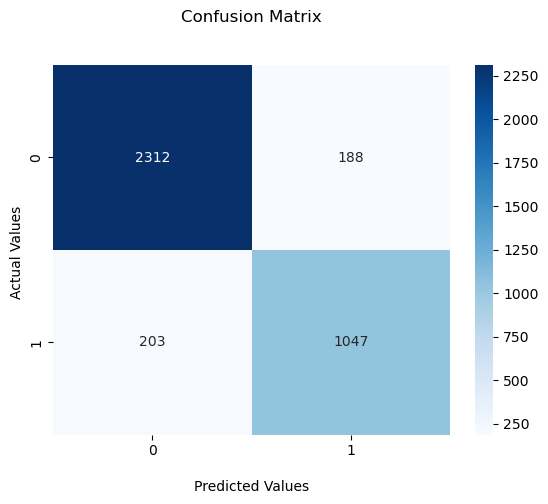

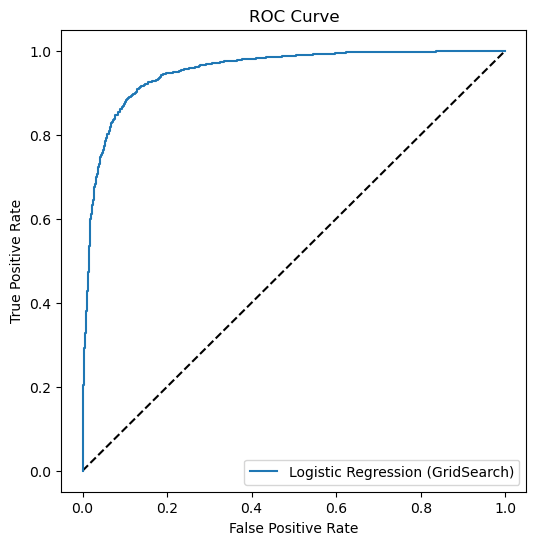

C:\Users\Mateusz\AppData\Local\Temp\ipykernel_26192\4219342804.py:44: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics_dataframe = pd.concat([metrics_dataframe, new_row], ignore_index=True)


,Model,F1_score,AUC
0,Logistic Regression (GridSearch),0.842656,0.951845


In [21]:
# Funkcje numeryczne
num_features = ['Pregnancies', 'PlasmaGlucose', 'DiastolicBloodPressure', 
                'TricepsThickness', 'SerumInsulin', 'BMI', 
                'DiabetesPedigree', 'Age']

# Funkcje kategoryczne (brak w tym przypadku)
cat_features = []

# przygotowanie wartości numerycznych
num_preparation = Pipeline(steps=[
    ('fill_missings', SimpleImputer(strategy='mean')),
    ('polynomial_features', PolynomialFeatures(degree=3)),
    ('scaler_1', StandardScaler()),
    ('pca', PCA(n_components=0.95)),
    ('scaler_2', StandardScaler())
])

# przygotowanie wartości kategorycznych (pominięte, bo brak cech kategorycznych)
cat_preparation = None

# transformer = wartości numeryczne oraz kategoryczne
data_preparation = ColumnTransformer(transformers=[
    ('numeric_preprocessing', num_preparation, num_features)
])

model_pipeline = Pipeline(steps=[('preprocessor', data_preparation),
                                    ('model', LogisticRegression(max_iter=10000))])
# Siatka hiperparametrów
params = {
    'preprocessor__numeric_preprocessing__fill_missings__strategy': ['mean', 'median'],
    'preprocessor__numeric_preprocessing__polynomial_features__degree': [1, 2, 3, 4],
    'preprocessor__numeric_preprocessing__pca__n_components': [0.85, 0.90, 0.95, 0.99, 0.99999],
    'model__C': np.logspace(-4, 4, 50)
}

# GridSearchCV
grid_search = GridSearchCV(
    model_pipeline,
    params,
    cv=10,
    n_jobs=-1,
    verbose=10,
    scoring='f1_macro'
)

# Przeprowadzenie GridSearch
grid_search.fit(X_train, y_train)

# Wyniki GridSearch
print("Najlepsze parametry:")
print(grid_search.best_params_)

print("\nNajlepszy wynik F1:")
print(grid_search.best_score_)

# Ocena modelu z najlepszymi parametrami
best_model = grid_search.best_estimator_
calculate_metrics(best_model, 'Logistic Regression (GridSearch)', X_test, y_test)

**#4 Podsumowanie**

Pipeline z zastosowaniem GridSearch wyraźnie poprawił wyniki modelu w porównaniu do wersji bez tej optymalizacji. Wartość F1_score wzrosła z 0.653595 do 0.842656, co stanowi poprawę o około 28,9%. Również parametr AUC zwiększył się z 0.859503 do 0.951845, co oznacza wzrost o około 10,8%. Te wyniki jednoznacznie pokazują, że dobór hiperparametrów za pomocą GridSearch znacząco podnosi jakość modelu.